In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset

import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import torchtext

# get dataloader
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe

In [4]:
sst_dataset = load_dataset("sst", "default")

Found cached dataset sst (/home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
print(sst_dataset.shape)
train_dataset = sst_dataset["train"]
validation_dataset = sst_dataset["validation"]
test_dataset = sst_dataset["test"]
print(train_dataset.shape)
print(validation_dataset.shape)
print(test_dataset.shape)

{'train': (8544, 4), 'validation': (1101, 4), 'test': (2210, 4)}
(8544, 4)
(1101, 4)
(2210, 4)


In [6]:
# print(train_dataset[0])

# use nltk to tokenize the sentences
train_dataset = train_dataset.map(lambda example: {'tokens': word_tokenize(example['sentence'])})
validation_dataset = validation_dataset.map(lambda example: {'tokens': word_tokenize(example['sentence'])})
test_dataset = test_dataset.map(lambda example: {'tokens': word_tokenize(example['sentence'])})
# print(train_dataset[0])
# print(test_dataset[0])

Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-bb5f67f2d04b9322.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-bfbc96d0e7322a91.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-010f98f8730a3aa6.arrow


In [7]:
# build the vocabulary

# convert all tokens to lowercase
train_dataset = train_dataset.map(lambda example: {'tokens': [token.lower() for token in example['tokens']]})
validation_dataset = validation_dataset.map(lambda example: {'tokens': [token.lower() for token in example['tokens']]})
test_dataset = test_dataset.map(lambda example: {'tokens': [token.lower() for token in example['tokens']]})

vocabulary = torchtext.vocab.build_vocab_from_iterator(train_dataset['tokens'], specials=["<unk>", "<pad>"], min_freq=2)
vocabulary.set_default_index(vocabulary["<unk>"])
print(f'Length of vocabulary: {len(vocabulary)}')
print(vocabulary.get_itos()[:10])
# print(vocabulary.get_stoi()["<unk>"])

Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-37e9605f1b6ee538.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-55d090e59212e70f.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-a723b3a64961bd66.arrow


Length of vocabulary: 8219
['<unk>', '<pad>', '.', 'the', ',', 'a', 'and', 'of', 'to', 'is']


In [8]:
# convert tokens to indices
train_indices = train_dataset.map(lambda example: {'tokens': [vocabulary[token] for token in example['tokens']]})
validation_indices = validation_dataset.map(lambda example: {'tokens': [vocabulary[token] for token in example['tokens']]})
test_indices = test_dataset.map(lambda example: {'tokens': [vocabulary[token] for token in example['tokens']]})
print(train_indices[0])
print(f'Largest sentence in training set has {max([len(example["tokens"]) for example in train_indices])} tokens')
print(f'Average sentence in training set has {np.mean([len(example["tokens"]) for example in train_indices])} tokens')

# pad the sentences
pad_index = vocabulary["<pad>"]
# insert the pad token at the end of each sentence until it reaches the max length
max_length = max([len(example["tokens"]) for example in train_indices])

# if any sentence in test set is longer than max_length, truncate it
test_indices = test_indices.map(lambda example: {'tokens': example['tokens'][:max_length]})


train_indices = train_indices.map(lambda example: {'tokens': example['tokens'] + [pad_index] * (max_length - len(example['tokens']))})
validation_indices = validation_indices.map(lambda example: {'tokens': example['tokens'] + [pad_index] * (max_length - len(example['tokens']))})
test_indices = test_indices.map(lambda example: {'tokens': example['tokens'] + [pad_index] * (max_length - len(example['tokens']))})
# print(train_indices[0])
# print(test_indices[0])
# print(len(train_indices[0]['tokens']))
# print(len(test_indices[2209]['tokens']))



Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-5686a57f19ff4596.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-3835c615e5dd4f80.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-770ed8583262ef70.arrow


{'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", 'label': 0.6944400072097778, 'tokens': [3, 612, 9, 3633, 8, 25, 3, 2832, 1280, 10, 106, 32, 6047, 32, 6, 12, 73, 10, 273, 8, 82, 5, 5359, 67, 3778, 40, 1882, 3292, 4, 0, 1859, 6160, 48, 892, 0, 2], 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}
Largest sentence in training set has 53 tokens
Average sentence in training set has 19.157069288389515 tokens


Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-8f3559959a6891bb.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-0749e7c625bcd606.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-7c3007290063b89c.arrow
Loading cached processed dataset at /home/prani/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-39c1fefd9cffbbef.arrow


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# print the lengths of all the token lists in the test set
# lister = ([len(example['tokens']) for example in test_indices])

# for el in lister:
#     if el != 53:
#         print(el)

cuda


In [10]:
# print(len(train_indices['tokens'][0]))
# print(len(test_indices['tokens'][0]))

train_indices_only =        np.array(train_indices["tokens"])
validation_indices_only =   np.array(validation_indices["tokens"])
test_indices_only =         np.array(test_indices["tokens"])

# print(train_indices_only[0].shape)
# print(test_indices_only[0].shape)
# print(test_indices_only.shape)
# # reshape the test_indices_only
# test_indices_only = test_indices_only.reshape(-1, max_length)

# print(train_indices_only.shape)
# print(test_indices_only.shape)

train_labels_only =         np.array(train_dataset["label"])
validation_labels_only =    np.array(validation_dataset["label"])
test_labels_only =          np.array(test_dataset["label"])

# if label is greater than 0.5, then make it 1, else make it 0
train_labels_only = np.where(train_labels_only >= 0.5, 1, 0)
validation_labels_only = np.where(validation_labels_only >= 0.5, 1, 0)
test_labels_only = np.where(test_labels_only >= 0.5, 1, 0)

# print(train_indices_only.shape)
# print(test_indices_only.shape)
# # print(train_labels_only.shape)
# print(test_labels_only.shape)

# print(train_indices_only[0])
# print(test_indices_only[0])

# batch the data
batch_size = 32
train_data = DataLoader(list(zip(train_indices_only, train_labels_only)), batch_size=batch_size, shuffle=True)
validation_data = DataLoader(list(zip(validation_indices_only, validation_labels_only)), batch_size=batch_size, shuffle=True)
test_data = DataLoader(list(zip(test_indices_only, test_labels_only)), batch_size=batch_size, shuffle=True)

# # check the data
# for batch in test_data:
#     print(batch[0])
#     print(batch[1])
#     print(batch[0].shape)
#     print(batch[1].shape)
#     break


In [11]:
# define the model as a sentence classifier using ELMO embeddings using two biLSTM layers and use glove embeddings for the words
class SentenceClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes=2, num_layers=2, dropout=0.5):
        super(SentenceClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.lstm1f = nn.LSTM(self.embedding_dim, self.hidden_dim, 1, bidirectional=False, batch_first=True, dropout=self.dropout)
        self.lstm1b = nn.LSTM(self.embedding_dim, self.hidden_dim, 1, bidirectional=False, batch_first=True, dropout=self.dropout)
        self.lstm2f = nn.LSTM(self.hidden_dim, self.hidden_dim, 1, bidirectional=False, batch_first=True, dropout=self.dropout)
        self.lstm2b = nn.LSTM(self.hidden_dim, self.hidden_dim, 1, bidirectional=False, batch_first=True, dropout=self.dropout)
        # self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.num_layers, bidirectional=True, dropout=self.dropout)
        self.linear = nn.Linear(self.hidden_dim * 4 + self.embedding_dim, self.num_classes)
        self.dropout = nn.Dropout(self.dropout)

    def forward(self, x):
        # x.shape = (batch_size, max_length)
        embedded = self.embedding(x)
        # embedded.shape = (batch_size, max_length, embedding_dim)
        # print(embedded.shape)
        output1f, (hidden1f, cell1f) = self.lstm1f(embedded)
        output1b, (hidden1b, cell1b) = self.lstm1b(embedded.flip(dims = [1]))
        # output1b, (hidden1b, cell1b) = self.lstm1b(embedded)
        output2f, (hidden2f, cell2f) = self.lstm2f(output1f)
        output2b, (hidden2b, cell2b) = self.lstm2b(output1b)
        # output.shape = (batch_size, max_length, hidden_dim)
        
        # concatenate the forward and backward outputs for both layers
        output1 = torch.cat((output1f, output1b), dim=2)
        output2 = torch.cat((output2f, output2b), dim=2)
        # output.shape = (batch_size, max_length, hidden_dim * 2)

        # pass these outputs through a linear layer along with the initial embedding
        output = torch.cat((output1, output2, embedded), dim=2)
        # output.shape = (batch_size, max_length, hidden_dim * 4 + embedding_dim)
        output = self.linear(output)
        # output.shape = (batch_size, max_length, num_classes)
        output = output[:, -1, :]
        # output.shape = (batch_size, num_classes)
        output = self.dropout(output)
        return output


        



    # def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes=2, num_layers=2, dropout=0.5):
    #     super(SentenceClassifier, self).__init__()
    #     self.embedding_dim = embedding_dim
    #     self.hidden_dim = hidden_dim
    #     self.vocab_size = vocab_size
    #     self.num_classes = num_classes
    #     self.num_layers = num_layers
    #     self.dropout = dropout

    #     self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
    #     self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.num_layers, bidirectional=True, batch_first=True, dropout=self.dropout)
    #     # self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.num_layers, bidirectional=True, dropout=self.dropout)
    #     self.linear = nn.Linear(self.hidden_dim * 2, self.num_classes)

    # def forward(self, x):
    #     # x.shape = (batch_size, sequence_length)
    #     embedded = self.embedding(x)
    #     # embedded.shape = (batch_size, sequence_length, embedding_dim)
    #     output, (hidden, cell) = self.lstm(embedded)
    #     # output.shape = (batch_size, sequence_length, hidden_dim * 2)
    #     # hidden.shape = (num_layers * 2, batch_size, hidden_dim)
    #     # cell.shape = (num_layers * 2, batch_size, hidden_dim)
    #     hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
    #     # hidden.shape = (batch_size, hidden_dim * 2)
    #     return self.linear(hidden)
    
    # def predict(self, x):
    #     logits = self.forward(x)
    #     return F.softmax(logits, dim=1)
    
    # def accuracy(self, y_pred, y_true):
    #     return torch.sum(torch.argmax(y_pred, dim=1) == y_true) / len(y_true)
    

In [12]:
# define the hyperparameters
embedding_dim = 300
hidden_dim = 256
vocab_size = len(vocabulary)
num_classes = 2
num_layers = 2
dropout = 0.5
learning_rate = 0.001
num_epochs = 10

# initialize the model
model = SentenceClassifier(embedding_dim, hidden_dim, vocab_size, num_classes, num_layers, dropout)
model.to(device)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/home/prani/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [45]:
# train the model
for epoch in range(num_epochs):
    model.train()
    for batch, (sentences, labels) in enumerate(train_data):
        sentences = sentences.to(device)
        labels = labels.to(device)

        outputs = model(sentences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f'Epoch: {epoch + 1}/{num_epochs}, Step: {batch}, Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for sentences, labels in validation_data:
            sentences = sentences.to(device)
            labels = labels.to(device)

            outputs = model(sentences)
            predictions = torch.argmax(outputs, dim=1)

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

        print(f'Epoch: {epoch + 1}/{num_epochs}, Validation Accuracy: {(correct / total) * 100:.2f}%')


Epoch: 1/10, Step: 0, Loss: 0.6982
Epoch: 1/10, Step: 100, Loss: 0.7196
Epoch: 1/10, Step: 200, Loss: 0.7167
Epoch: 1/10, Validation Accuracy: 56.31%
Epoch: 2/10, Step: 0, Loss: 0.7222
Epoch: 2/10, Step: 100, Loss: 0.6523
Epoch: 2/10, Step: 200, Loss: 0.5753
Epoch: 2/10, Validation Accuracy: 67.76%
Epoch: 3/10, Step: 0, Loss: 0.5481
Epoch: 3/10, Step: 100, Loss: 0.4813
Epoch: 3/10, Step: 200, Loss: 0.5190
Epoch: 3/10, Validation Accuracy: 70.94%
Epoch: 4/10, Step: 0, Loss: 0.4135
Epoch: 4/10, Step: 100, Loss: 0.5315
Epoch: 4/10, Step: 200, Loss: 0.3137
Epoch: 4/10, Validation Accuracy: 71.12%
Epoch: 5/10, Step: 0, Loss: 0.2442
Epoch: 5/10, Step: 100, Loss: 0.3515
Epoch: 5/10, Step: 200, Loss: 0.3524
Epoch: 5/10, Validation Accuracy: 71.93%
Epoch: 6/10, Step: 0, Loss: 0.2637
Epoch: 6/10, Step: 100, Loss: 0.2783
Epoch: 6/10, Step: 200, Loss: 0.2601
Epoch: 6/10, Validation Accuracy: 71.48%
Epoch: 7/10, Step: 0, Loss: 0.2151
Epoch: 7/10, Step: 100, Loss: 0.2039
Epoch: 7/10, Step: 200, Loss

In [46]:
# test the model
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for sentences, labels in test_data:
        # print(sentences)
        sentences = sentences.to(device)
        labels = labels.to(device)

        outputs = model(sentences)
        predictions = torch.argmax(outputs, dim=1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    print(f'Test Accuracy: {(correct / total) * 100:.2f}%')

# save the model
torch.save(model.state_dict(), 'model.pt')

Test Accuracy: 71.49%


In [13]:
# load the model
model = SentenceClassifier(embedding_dim, hidden_dim, vocab_size, num_classes, num_layers, dropout)
model.load_state_dict(torch.load('model.pt'))
model.to(device)

SentenceClassifier(
  (embedding): Embedding(8219, 300)
  (lstm1f): LSTM(300, 256, batch_first=True, dropout=0.5)
  (lstm1b): LSTM(300, 256, batch_first=True, dropout=0.5)
  (lstm2f): LSTM(256, 256, batch_first=True, dropout=0.5)
  (lstm2b): LSTM(256, 256, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=1324, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [14]:
# use sklearn to get the classification report
from sklearn.metrics import classification_report
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for sentences, labels in test_data:
        sentences = sentences.to(device)
        labels = labels.to(device)

        outputs = model(sentences)
        predictions = torch.argmax(outputs, dim=1)

        y_pred.extend(predictions.tolist())
        y_true.extend(labels.tolist())

    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.76      0.63      0.69      1099
    Positive       0.69      0.80      0.74      1111

    accuracy                           0.71      2210
   macro avg       0.72      0.71      0.71      2210
weighted avg       0.72      0.71      0.71      2210



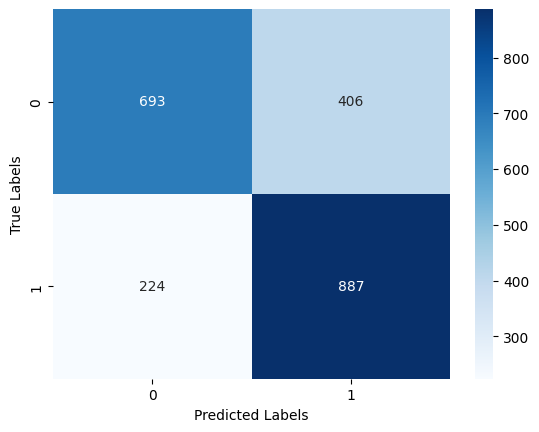

In [16]:
# generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for sentences, labels in test_data:
        sentences = sentences.to(device)
        labels = labels.to(device)

        outputs = model(sentences)
        predictions = torch.argmax(outputs, dim=1)

        y_pred.extend(predictions.tolist())
        y_true.extend(labels.tolist())

    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()

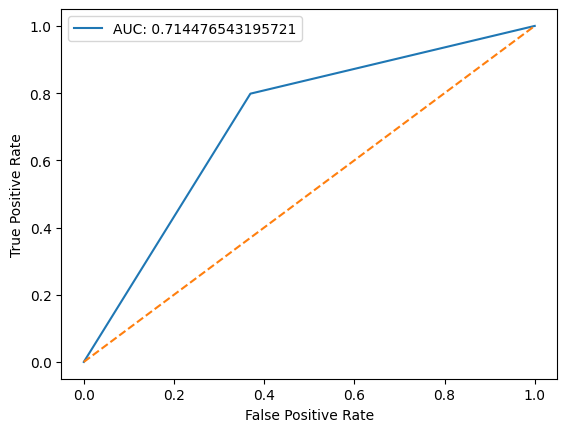

In [17]:
# generate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for sentences, labels in test_data:
        sentences = sentences.to(device)
        labels = labels.to(device)

        outputs = model(sentences)
        predictions = torch.argmax(outputs, dim=1)

        y_pred.extend(predictions.tolist())
        y_true.extend(labels.tolist())

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label=f'AUC: {auc}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()